<a href="https://colab.research.google.com/github/Pacoanes/State-of-the-art/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append("..")
#import download_utils
#import tqdm_utils
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from keras import backend as K


In [0]:
def detect_faces(cascade, test_image):
    image_copy = test_image.copy()
    faces_rect = cascade.detectMultiScale(image_copy, minSize=(50, 50), scaleFactor=1.1, minNeighbors=10)
    
    if (faces_rect==()): # si no reconoce cara
        return 0
      
    else:
        for (x, y, w, h) in faces_rect:
            r = max(w, h) / 1.17
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)
    faceimg = image_copy[ny:ny+nr+10, nx:nx+nr+10]

    return faceimg

In [0]:
cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [69]:
drive.mount("/content/drive", force_remount=True)
path = "/content/drive/My Drive/ban/raw1"
training_data = []
for img in os.listdir(path):  
    try:
        img_array = cv2.imread(os.path.join(path,img))  
        faces = detect_faces(cascade_face, img_array)
        img_rgb = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_rgb, (72, 72))
        training_data.append(new_array)
    except Exception as e:  
        pass
print(len(training_data))

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


1366


In [0]:
training_dat = np.float32(training_data)/255.

In [71]:
IMG_SHAPE_ban=training_dat.shape[1:]
IMG_SHAPE_ban

(72, 72, 3)

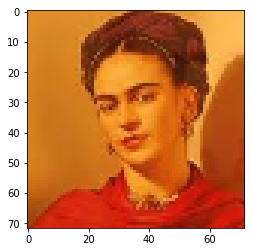

In [72]:
plt.imshow(training_dat[np.random.randint(training_dat.shape[0])], cmap="gray", interpolation="none")

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
#librerias para GAN
import tensorflow as tf
#from keras_utils import reset_tf_session
import keras
from keras.models import Sequential
from keras import layers as L

In [0]:
s = reset_tf_session()

In [76]:
#red generadora
CODE_SIZE = 512

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(18*8*8, activation='elu'))
generator.add(L.Reshape((8,8,18)))
generator.add(L.Deconv2D(128,kernel_size=(4,4),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(4,4),activation='elu'))
generator.add(L.UpSampling2D(size=(5,5)))
generator.add(L.Deconv2D(32,kernel_size=2,activation='elu'))
generator.add(L.Deconv2D(16,kernel_size=2,activation='elu'))
generator.add(L.Deconv2D(8,kernel_size=2,activation='elu'))
generator.add(L.Conv2D(3,kernel_size=2,activation=None))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1152)              590976    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 11, 11, 128)       36992     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        131136    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 71, 71, 32)        8224      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 72, 72, 16)        2064      
__________

In [77]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE_ban))

discriminator.add(L.Conv2D(8, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(16, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(32, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(64, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))


# <build discriminator body>

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 70, 70, 8)         224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 8)         32        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 70, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 68, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 68, 68, 16)        64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 68, 68, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
__________

In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE_ban))

logp_real = discriminator(real_data)

generated_data = generator(noise) #<gen(noise)>

logp_gen = discriminator(generated_data) #<log P(real | gen(noise))




In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
 
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [0]:
########################
###generator training###
########################

g_loss = tf.reduce_mean(logp_gen[:,0]) # <generator loss>

gen_optimizer =tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)
    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(training_dat.shape[0]), size=bsize)
    return training_dat[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(training_dat),np.max(training_dat))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

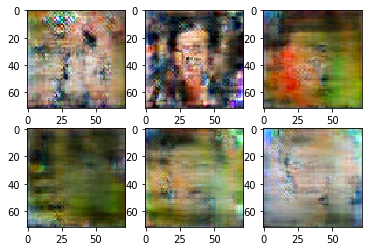

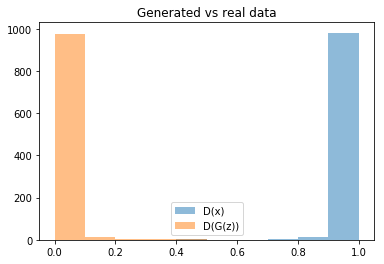




 27%|██▋       | 13301/50000 [1:57:21<9:21:54,  1.09it/s]


 27%|██▋       | 13302/50000 [1:57:21<8:07:00,  1.26it/s]


 27%|██▋       | 13303/50000 [1:57:22<7:16:14,  1.40it/s]


 27%|██▋       | 13304/50000 [1:57:22<6:38:51,  1.53it/s]


 27%|██▋       | 13305/50000 [1:57:23<6:13:37,  1.64it/s]


 27%|██▋       | 13306/50000 [1:57:23<5:55:02,  1.72it/s]


 27%|██▋       | 13307/50000 [1:57:24<5:43:45,  1.78it/s]


 27%|██▋       | 13308/50000 [1:57:24<5:35:32,  1.82it/s]


 27%|██▋       | 13309/50000 [1:57:25<5:29:23,  1.86it/s]


 27%|██▋       | 13310/50000 [1:57:25<5:26:21,  1.87it/s]


 27%|██▋       | 13311/50000 [1:57:26<5:22:51,  1.89it/s]


 27%|██▋       | 13312/50000 [1:57:27<5:20:23,  1.91it/s]


 27%|██▋       | 13313/50000 [1:57:27<5:18:15,  1.92it/s]


 27%|██▋       | 13314/50000 [1:57:28<5:16:09,  1.93it/s]


 27%|██▋       | 13315/50000 [1:57:28<5:16:31,  1.93it/s]


 27%|██▋       | 13316/50000 [1:57:29<5:16:39,  1.93it/s]


 27%|██▋       | 13317/50000 [1:57:29

KeyboardInterrupt: ignored

In [83]:
from IPython import display
from tqdm import tqdm
for epoch in tqdm(range(50000)):
  
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
  
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
  
    s.run(gen_optimizer,feed_dict)
  
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

In [0]:
plt.figure(figsize=[16,24])
sample_images(16,8)